# Sentinel-5P NO2 in South Korea

## Environment Setup

In [1]:
# Load Notebook formatter
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Imports
import os
import glob
import pytz
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import geopandas as gpd
import rasterio as rio
import earthpy.plot as ep
import radiance as rd
import sentinel as stl

<IPython.core.display.Javascript object>

In [3]:
# Set options
register_matplotlib_converters()
sns.set(font_scale=1.5, style="whitegrid")
np.set_printoptions(suppress=True)

<IPython.core.display.Javascript object>

In [4]:
# Set working directory
os.chdir("..")
print(f"Working directory: {os.getcwd()}")

Working directory: C:\PSU\08-covid19-remote-sensing-fusion\00-git-repos\sentinel-5p-no2


<IPython.core.display.Javascript object>

## Data Acquisition & Preprocessing

### NO2 Mean Data

In [5]:
# Get path to pre- and post-change data
no2_2019_tif_path = os.path.join(
    "03-processed-data",
    "raster",
    "south-korea",
    "statistics",
    "S5P-OFFL-L3-NO2-20190101-20190630-MEAN-MOL-PER-M2.tif",
)
no2_2020_tif_path = os.path.join(
    "03-processed-data",
    "raster",
    "south-korea",
    "statistics",
    "S5P-OFFL-L3-NO2-20200101-20200630-MEAN-MOL-PER-M2.tif",
)

# Read data into arrays
no2_mean_20190101_20190630 = stl.read_geotiff_into_array(no2_2019_tif_path)
no2_mean_20200101_20200630 = stl.read_geotiff_into_array(no2_2020_tif_path)

<IPython.core.display.Javascript object>

In [6]:
# Confirm equal array shapes
no2_mean_20190101_20190630.shape == no2_mean_20200101_20200630.shape

True

<IPython.core.display.Javascript object>

### Plotting Extent

In [7]:
# Extract plotting extent
south_korea_extent = stl.extract_plotting_extent(no2_2019_tif_path)
print(f"South Korea Extent: {south_korea_extent}")

South Korea Extent: (125.0, 131.0, 33.1, 38.7)


<IPython.core.display.Javascript object>

### South Korea Boundary

In [8]:
# Define path to South Korea shapefile
south_korea_shp_path = os.path.join(
    "02-raw-data", "vector", "south-korea", "gadm36_south_korea.shp"
)

# Read South Korea shapefile into geodataframe and project if necessary
south_korea_boundary = stl.project_vector(
    vector_path=south_korea_shp_path, raster_path=no2_2019_tif_path
)

# Create extent polygon
south_korea_polygon = stl.create_polygon_from_extent(south_korea_extent)

print(f"South Korea CRS: {south_korea_boundary.crs}")
print(f"South Korea Bounds:\n{south_korea_boundary.bounds.loc[0]}")

South Korea CRS: epsg:4326
South Korea Bounds:
minx    125.081802
miny     33.112083
maxx    130.940414
maxy     38.612152
Name: 0, dtype: float64


<IPython.core.display.Javascript object>

### North Korea Boundary

In [9]:
# Define path to North Korea shapefile
north_korea_shp_path = os.path.join(
    "02-raw-data", "vector", "north-korea", "gadm36_north_korea.shp"
)

# Read North Korea shapefile into geodataframe and project if necessary
north_korea_boundary = stl.project_vector(
    vector_path=north_korea_shp_path, raster_path=no2_2019_tif_path
)

print(f"North Korea CRS: {north_korea_boundary.crs}")
print(f"North Korea Bounds:\n{north_korea_boundary.bounds.loc[0]}")

# Clip North Korea to South Korea extent polygon
north_korea_boundary_clipped = gpd.clip(
    gpd.GeoDataFrame(
        geometry=[south_korea_polygon], crs=north_korea_boundary.crs
    ),
    north_korea_boundary,
)

print(f"\nNorth Korea Clipped CRS: {north_korea_boundary_clipped.crs}")
print(
    f"North Korea Clipped Bounds:\n{north_korea_boundary_clipped.bounds.loc[0]}"
)

North Korea CRS: epsg:4326
North Korea Bounds:
minx    124.182358
miny     37.602917
maxx    130.674393
maxy     43.006050
Name: 0, dtype: float64

North Korea Clipped CRS: epsg:4326
North Korea Clipped Bounds:
minx    125.000000
miny     37.602917
maxx    128.368744
maxy     38.700000
Name: 0, dtype: float64


<IPython.core.display.Javascript object>

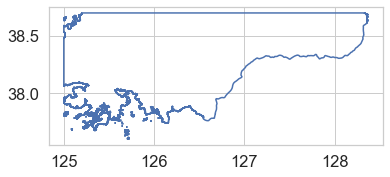

<IPython.core.display.Javascript object>

In [10]:
# Display clipped boundary
north_korea_boundary_clipped.boundary.plot()

## Data Processing

### NO2 Percent Change

In [11]:
# Calculate difference
no2_difference = no2_mean_20200101_20200630 - no2_mean_20190101_20190630

<IPython.core.display.Javascript object>

In [12]:
# Calculate the percent change
percent_change = (
    np.divide(
        (no2_mean_20200101_20200630 - no2_mean_20190101_20190630),
        no2_mean_20190101_20190630,
    )
    * 100
)
print(f"Percent change type: {type(percent_change)}")
print(f"Percent change min: {percent_change.min()}")
print(f"Percent change max: {percent_change.max()}")

Percent change type: <class 'numpy.ndarray'>
Percent change min: -43.31864253700623
Percent change max: 26.743942753438652


<IPython.core.display.Javascript object>

### NO2 Time Series

In [13]:
# Get Level-3 files into list
level3_files = glob.glob(
    os.path.join(
        "03-processed-data", "raster", "south-korea", "daily", "*.tif"
    )
)

<IPython.core.display.Javascript object>

In [14]:
# Get list of timestamps, NO2 means, and percent masked into arrays
timestamps = []
means = []
percent_masked = []
for level3_file in level3_files:

    # Parse timestamp and create datetime object
    timestamp = os.path.basename(level3_file)[27:46].split("-")
    year, month, day = list(map(int, timestamp[:-1]))
    hour, minute, second = list(
        map(int, [timestamp[3][1:3], timestamp[3][3:5], timestamp[3][5:7]])
    )
    timestamps.append(
        pd.datetime(year, month, day, hour, minute, second, tzinfo=pytz.utc)
    )

    # Calculate NO2 mean and percent masked
    with rio.open(level3_file) as file:
        means.append(np.nanmean(file.read(1)))
        percent_masked.append(rd.calculate_percent_masked(file.read(1)))

# Convert lists to arrays (for plotting)
timestamps_arr, means_arr, percent_masked_arr = (
    np.array(timestamps),
    np.array(means),
    np.array(percent_masked),
)

<IPython.core.display.Javascript object>

## Data Visualization

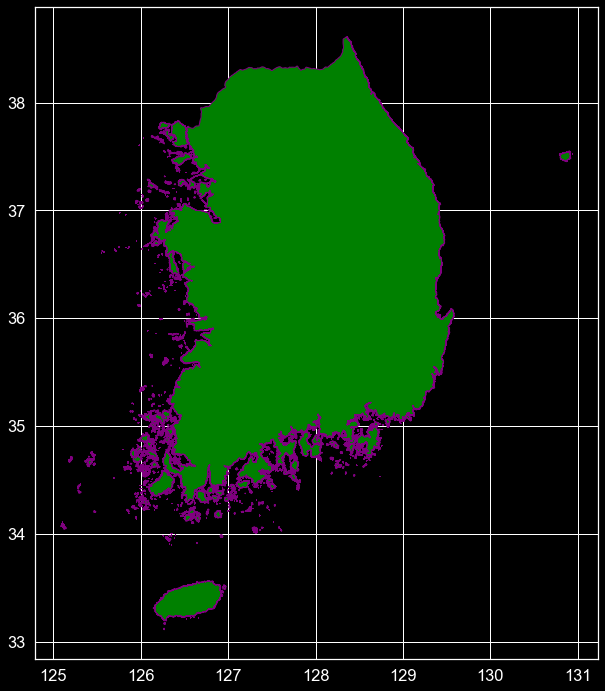

<IPython.core.display.Javascript object>

In [15]:
# Plot South Korea boundary
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(12, 12))
    south_korea_boundary.boundary.plot(
        facecolor="green", edgecolor="purple", linewidth=1, ax=ax
    )

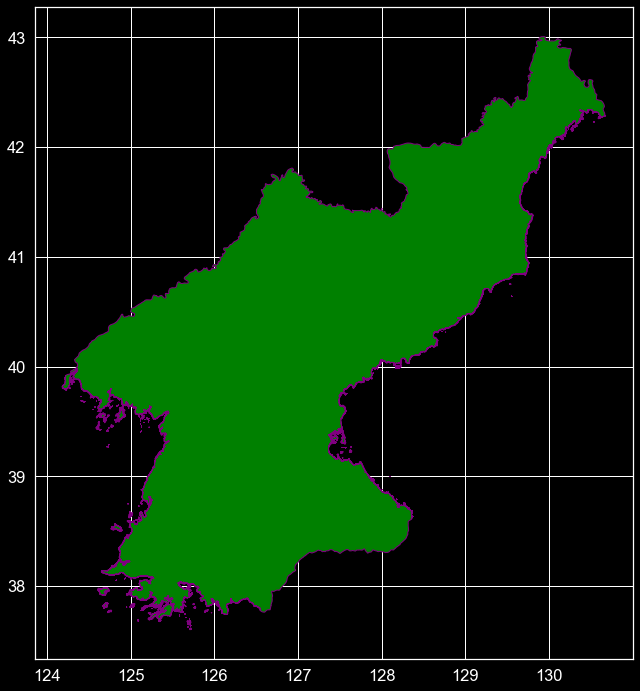

<IPython.core.display.Javascript object>

In [16]:
# Plot North Korea boundary
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(12, 12))
    north_korea_boundary.boundary.plot(
        facecolor="green", edgecolor="purple", linewidth=1, ax=ax
    )

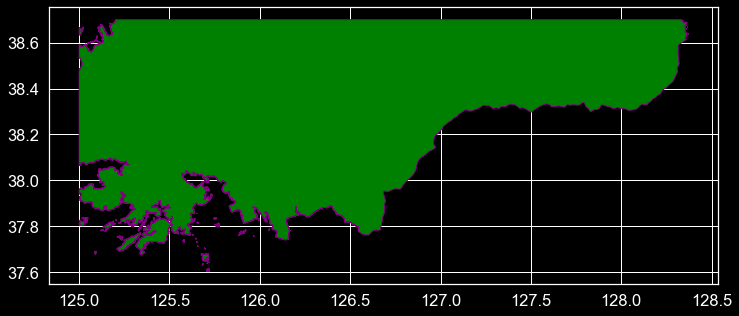

<IPython.core.display.Javascript object>

In [17]:
# Plot North Korea clipped boundary
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(12, 12))
    north_korea_boundary_clipped.boundary.plot(
        facecolor="green", edgecolor="purple", linewidth=1, ax=ax
    )

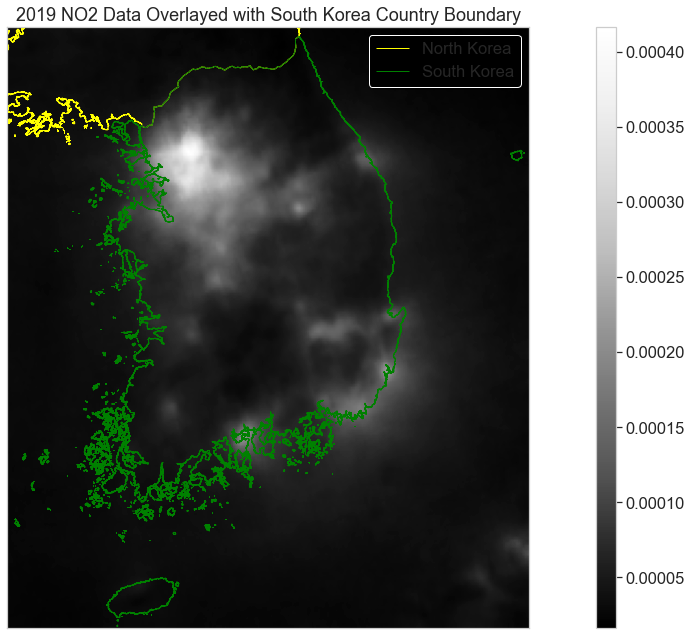

<IPython.core.display.Javascript object>

In [18]:
# Plot South Korea boundary over 2019 NO2 data
fig, ax = plt.subplots(figsize=(12, 12))
ep.plot_bands(
    no2_mean_20190101_20190630,
    ax=ax,
    title="2019 NO2 Data Overlayed with South Korea Country Boundary",
    extent=south_korea_extent,
)

north_korea_boundary_clipped.boundary.plot(
    edgecolor="yellow", linewidth=1, ax=ax, alpha=1, label="North Korea"
)

south_korea_boundary.boundary.plot(
    edgecolor="green", linewidth=1, ax=ax, alpha=1, label="South Korea"
)

ax.legend(
    shadow=True, facecolor="black", edgecolor="white",
)

plt.show()

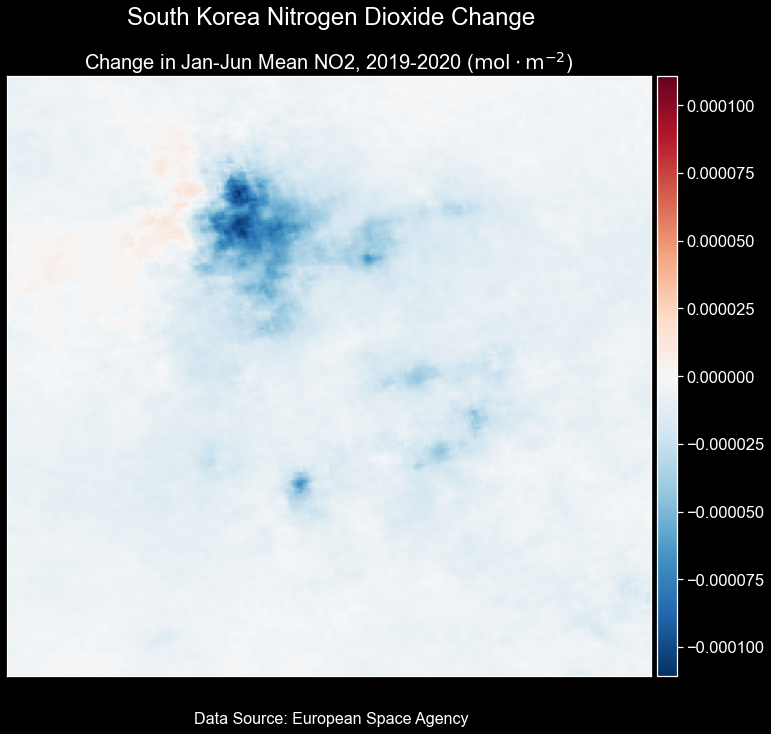

<IPython.core.display.Javascript object>

In [19]:
# Plot the 2019 to 2020 change
fig, ax = stl.plot_change(
    no2_mean_20190101_20190630,
    no2_mean_20200101_20200630,
    title="Change in Jan-Jun Mean NO2, 2019-2020",
)
plt.show()

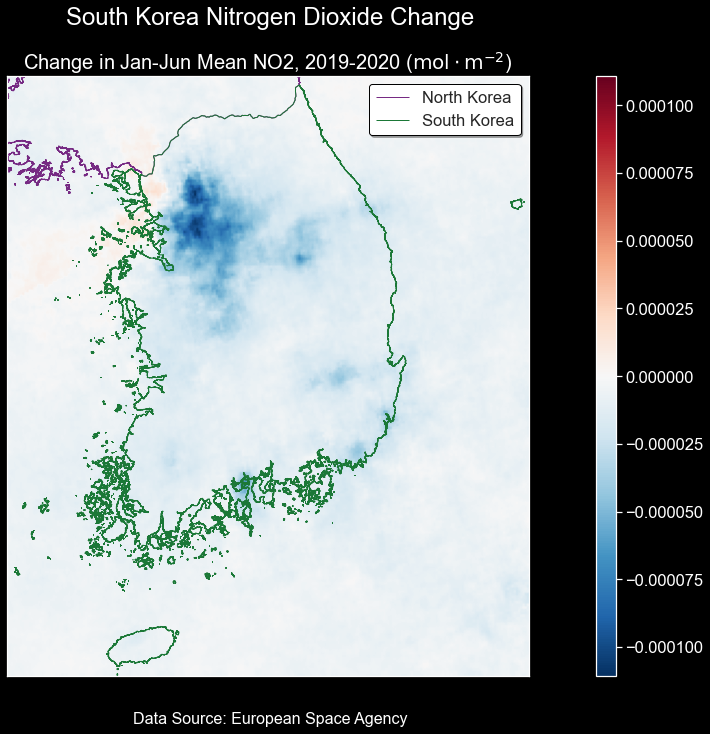

<IPython.core.display.Javascript object>

In [20]:
# Plot the 2019 to 2020 change, with boundary
fig, ax = stl.plot_change_with_boundary(
    no2_mean_20190101_20190630,
    no2_mean_20200101_20200630,
    extent_file=no2_2019_tif_path,
    title="Change in Jan-Jun Mean NO2, 2019-2020",
)

north_korea_boundary_clipped.boundary.plot(
    edgecolor="#762a83", linewidth=1, ax=ax, alpha=1, label="North Korea"
)

south_korea_boundary.boundary.plot(
    edgecolor="#1b7837", linewidth=1, ax=ax, alpha=1, label="South Korea"
)

ax.legend(
    shadow=True, edgecolor="black",
)

plt.show()

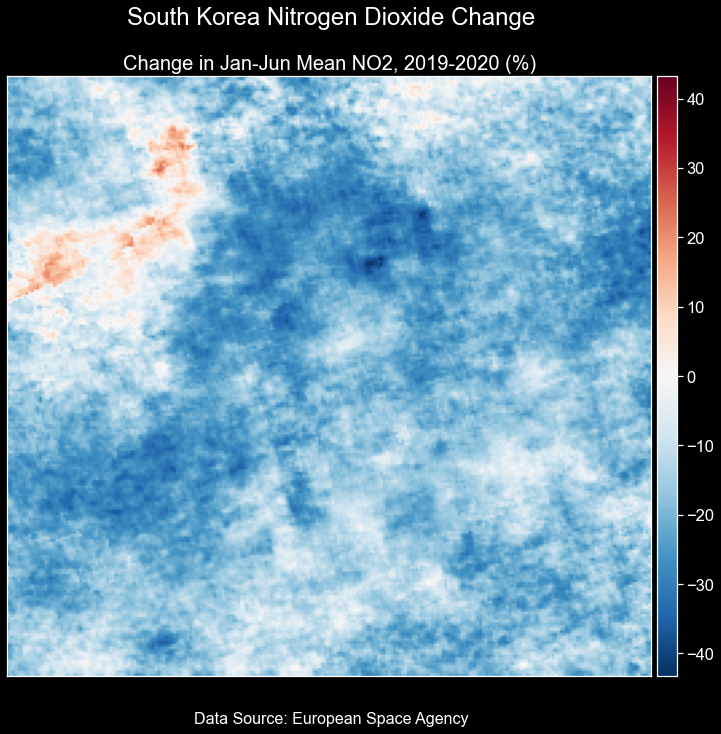

<IPython.core.display.Javascript object>

In [21]:
# Plot percent change
fig = stl.plot_percent_change(
    percent_change, title="Change in Jan-Jun Mean NO2, 2019-2020"
)
plt.show()

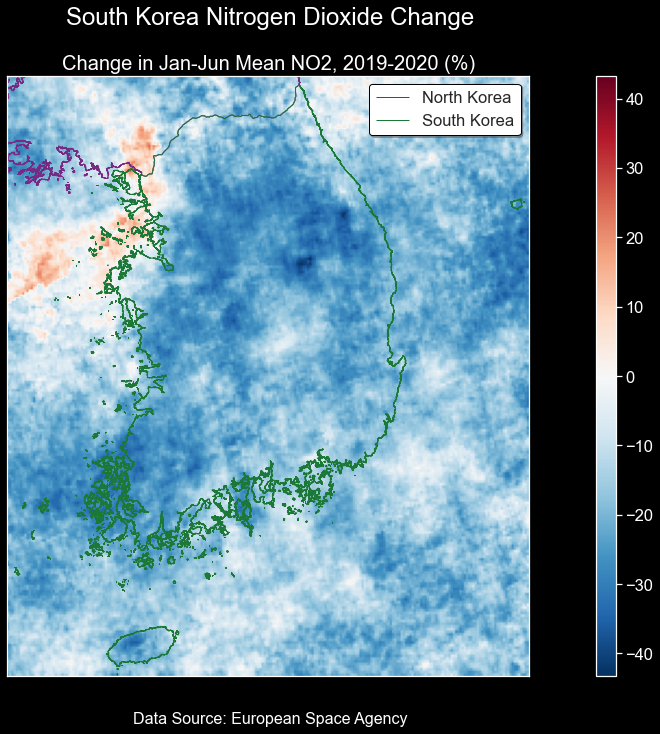

<IPython.core.display.Javascript object>

In [22]:
# Plot percent change, with boundary
fig, ax = stl.plot_percent_change_with_boundary(
    percent_change,
    extent_file=no2_2019_tif_path,
    title="Change in Jan-Jun Mean NO2, 2019-2020",
)

north_korea_boundary_clipped.boundary.plot(
    edgecolor="#762a83", linewidth=1, ax=ax, alpha=1, label="North Korea"
)

south_korea_boundary.boundary.plot(
    edgecolor="#1b7837", linewidth=1, ax=ax, alpha=1, label="South Korea"
)

ax.legend(shadow=True, edgecolor="black")

plt.show()

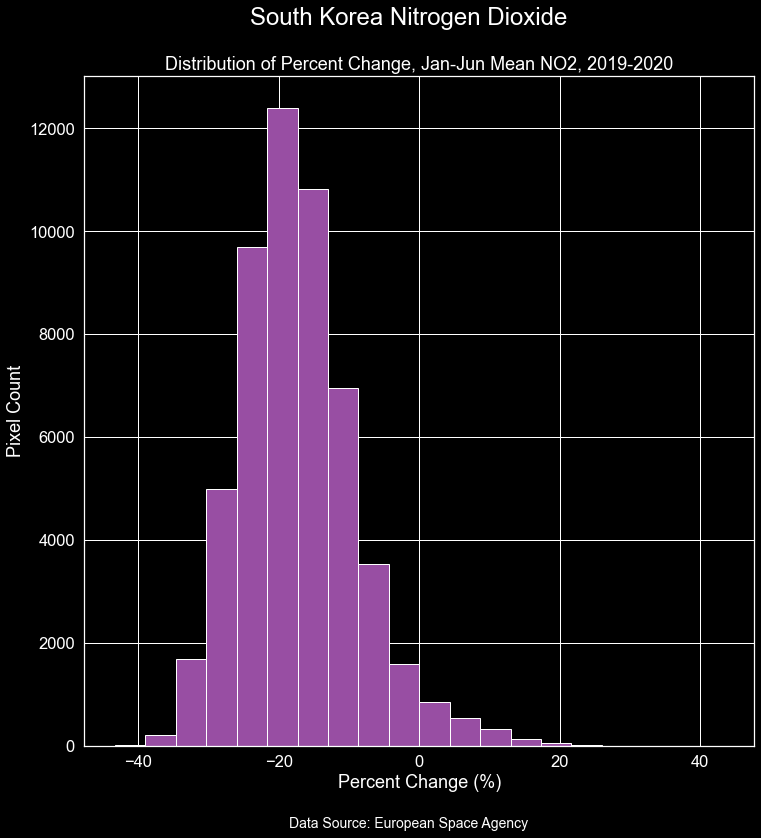

<IPython.core.display.Javascript object>

In [23]:
# Plot histogram of percent change
fig = stl.plot_histogram(percent_change)
plt.show()

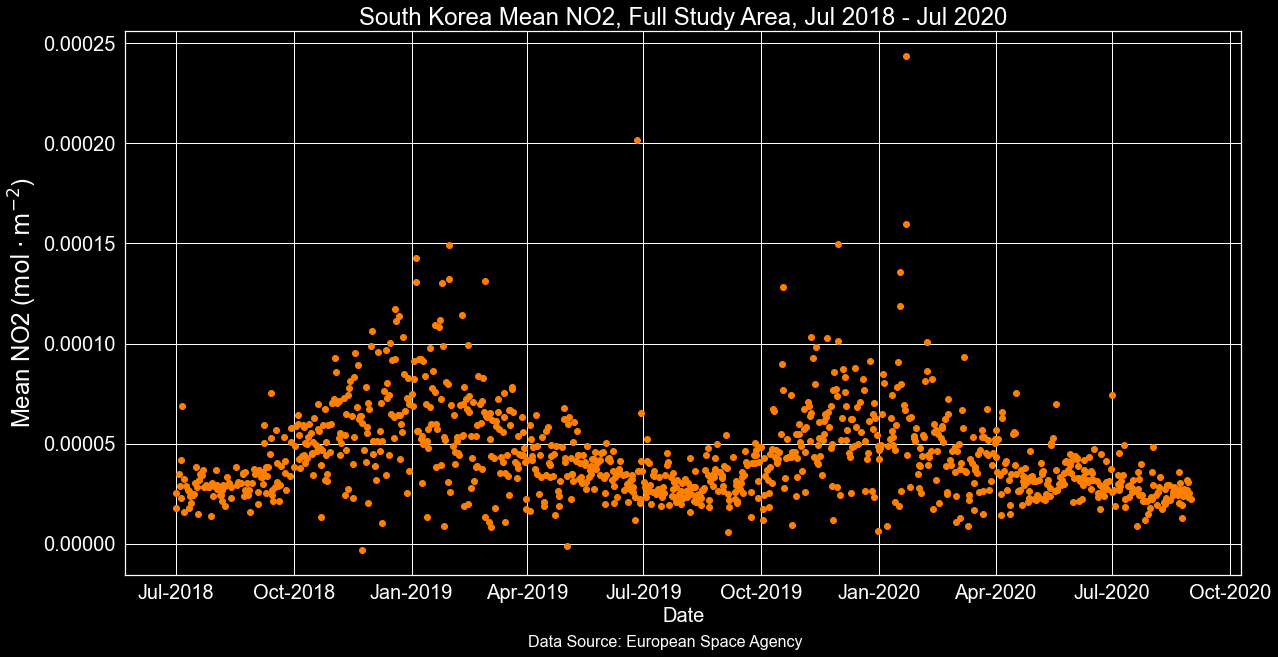

<IPython.core.display.Javascript object>

In [24]:
# Plot full study area time series mean
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(timestamps_arr, means_arr, facecolor="#ff7f00")
    ax.set_title(
        "South Korea Mean NO2, Full Study Area, Jul 2018 - Jul 2020", size=24
    )
    ax.set_xlabel("Date", size=20)
    ax.set_ylabel("Mean NO2 ($\mathrm{mol \cdot m^{-2}}$)", size=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    fig.text(
        0.5,
        0.025,
        "Data Source: European Space Agency",
        ha="center",
        fontsize=16,
    )

plt.show()

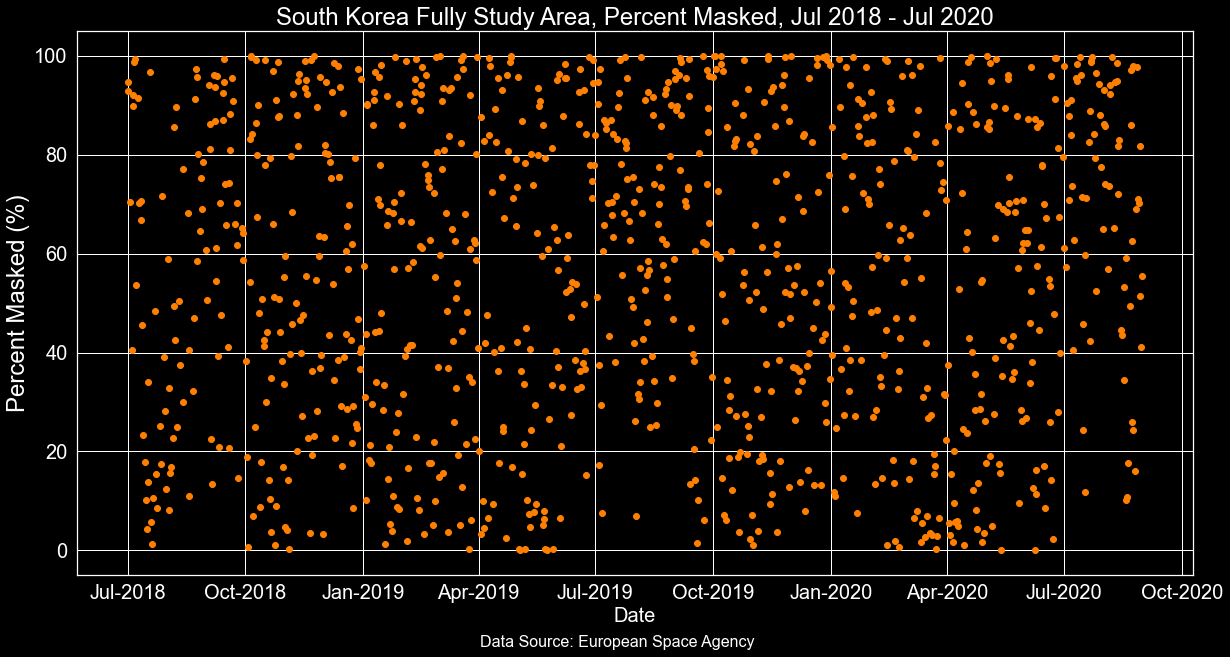

<IPython.core.display.Javascript object>

In [25]:
# Plot full study area time series percent masked
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(timestamps_arr, percent_masked_arr, facecolor="#ff7f00")
    ax.set_title(
        "South Korea Fully Study Area, Percent Masked, Jul 2018 - Jul 2020",
        size=24,
    )
    ax.set_xlabel("Date", size=20)
    ax.set_ylabel("Percent Masked (%)", size=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    fig.text(
        0.5,
        0.025,
        "Data Source: European Space Agency",
        ha="center",
        fontsize=16,
    )

plt.show()

## Data Export

### Non-Georeferenced

Saved plot: south-korea-no2-mean-change-jan-jun-2019-2020.png


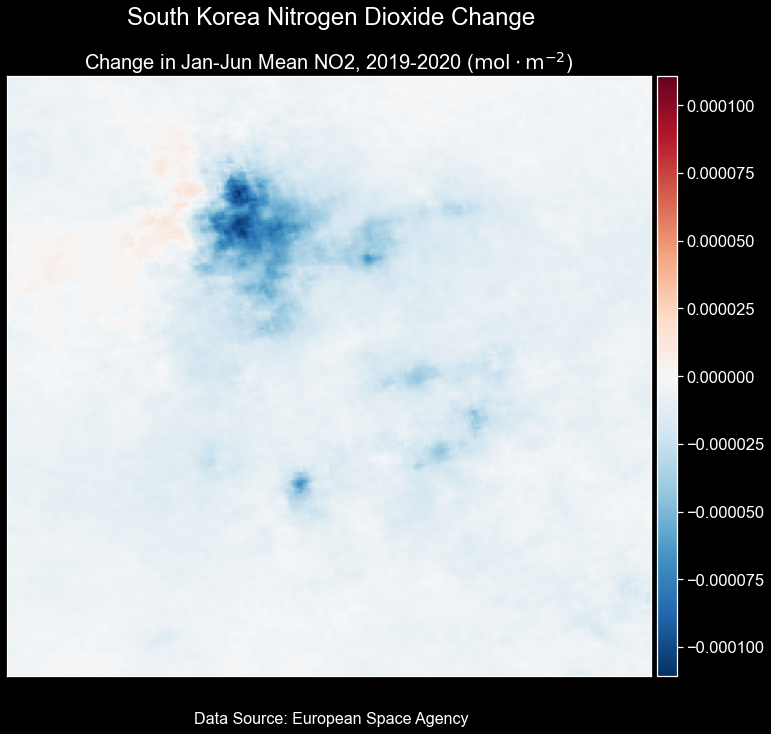

<IPython.core.display.Javascript object>

In [26]:
# Export 2019 to 2020 change
fig = stl.plot_change(
    no2_mean_20190101_20190630,
    no2_mean_20200101_20200630,
    title="Change in Jan-Jun Mean NO2, 2019-2020",
)

rd.save_figure(
    os.path.join(
        "04-graphics-outputs",
        "spatial-plots",
        "south-korea",
        "south-korea-no2-mean-change-jan-jun-2019-2020.png",
    )
)

Saved plot: south-korea-no2-mean-change-jan-jun-2019-2020-with-boundary.png


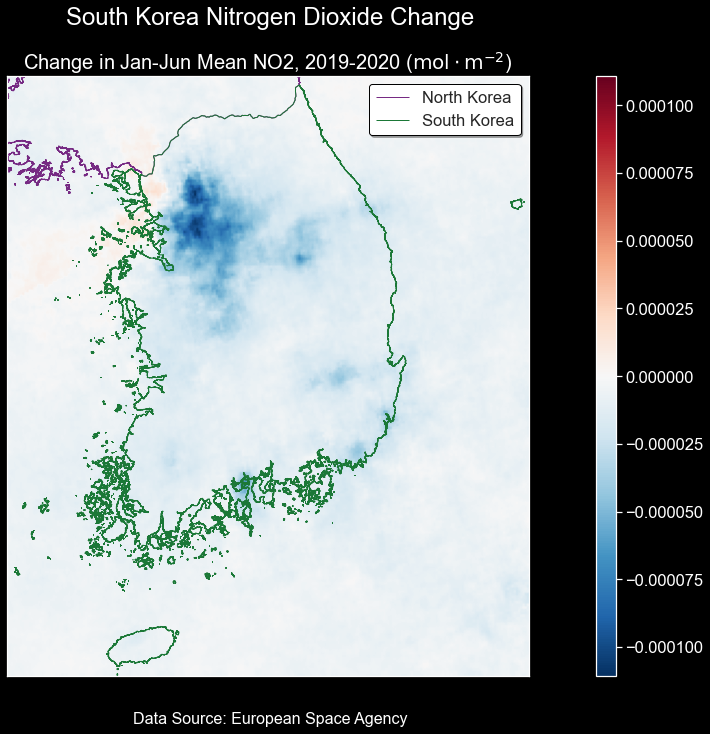

<IPython.core.display.Javascript object>

In [27]:
# Plot the change only, with boundary, and export
fig, ax = stl.plot_change_with_boundary(
    no2_mean_20190101_20190630,
    no2_mean_20200101_20200630,
    extent_file=no2_2019_tif_path,
    title="Change in Jan-Jun Mean NO2, 2019-2020",
)

north_korea_boundary_clipped.boundary.plot(
    edgecolor="#762a83", linewidth=1, ax=ax, alpha=1, label="North Korea"
)

south_korea_boundary.boundary.plot(
    edgecolor="#1b7837", linewidth=1, ax=ax, alpha=1, label="South Korea"
)

ax.legend(
    shadow=True, edgecolor="black",
)

rd.save_figure(
    os.path.join(
        "04-graphics-outputs",
        "spatial-plots",
        "south-korea",
        "south-korea-no2-mean-change-jan-jun-2019-2020-with-boundary.png",
    )
)

Saved plot: south-korea-no2-mean-change-percent-jan-jun-2019-2020.png


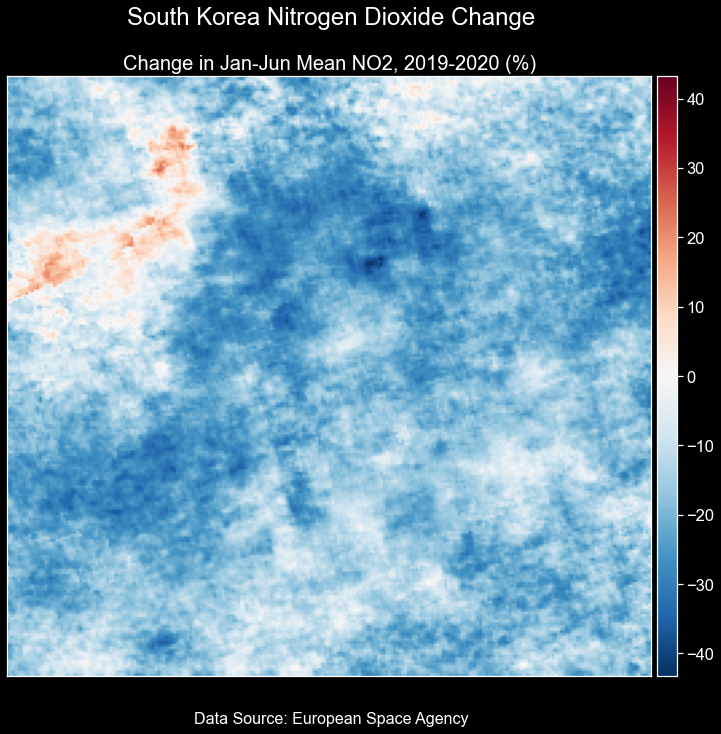

<IPython.core.display.Javascript object>

In [28]:
# Plot and export percent change
fig = stl.plot_percent_change(
    percent_change, title="Change in Jan-Jun Mean NO2, 2019-2020"
)

rd.save_figure(
    os.path.join(
        "04-graphics-outputs",
        "spatial-plots",
        "south-korea",
        "south-korea-no2-mean-change-percent-jan-jun-2019-2020.png",
    )
)

Saved plot: south-korea-no2-mean-change-percent-jan-jun-2019-2020-with-boundary.png


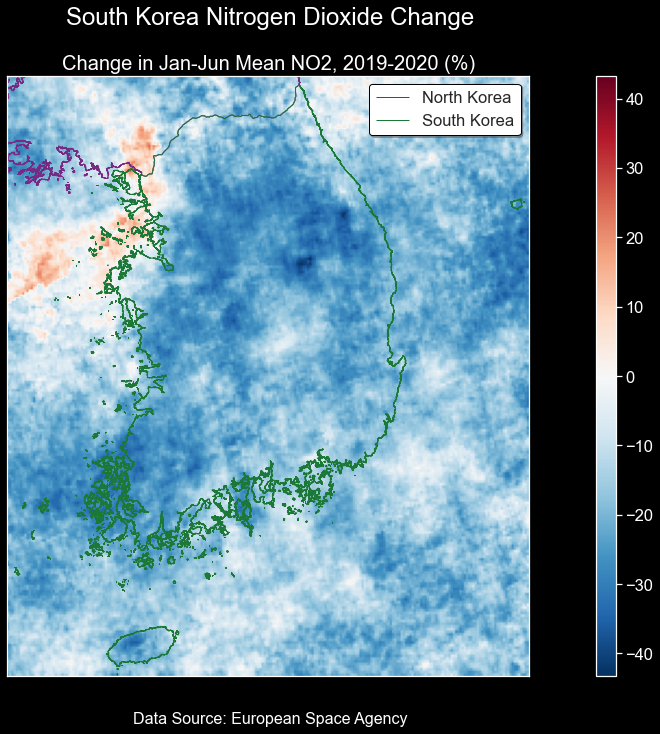

<IPython.core.display.Javascript object>

In [29]:
# Plot percent change, with boundary
fig, ax = stl.plot_percent_change_with_boundary(
    percent_change,
    extent_file=no2_2019_tif_path,
    title="Change in Jan-Jun Mean NO2, 2019-2020",
)

north_korea_boundary_clipped.boundary.plot(
    edgecolor="#762a83", linewidth=1, ax=ax, alpha=1, label="North Korea"
)

south_korea_boundary.boundary.plot(
    edgecolor="#1b7837", linewidth=1, ax=ax, alpha=1, label="South Korea"
)

ax.legend(
    shadow=True, edgecolor="black",
)

rd.save_figure(
    os.path.join(
        "04-graphics-outputs",
        "spatial-plots",
        "south-korea",
        "south-korea-no2-mean-change-percent-jan-jun-2019-2020-with-boundary.png",
    )
)

Saved plot: south-korea-no2-mean-change-percent-histogram-jan-jun-2019-2020.png


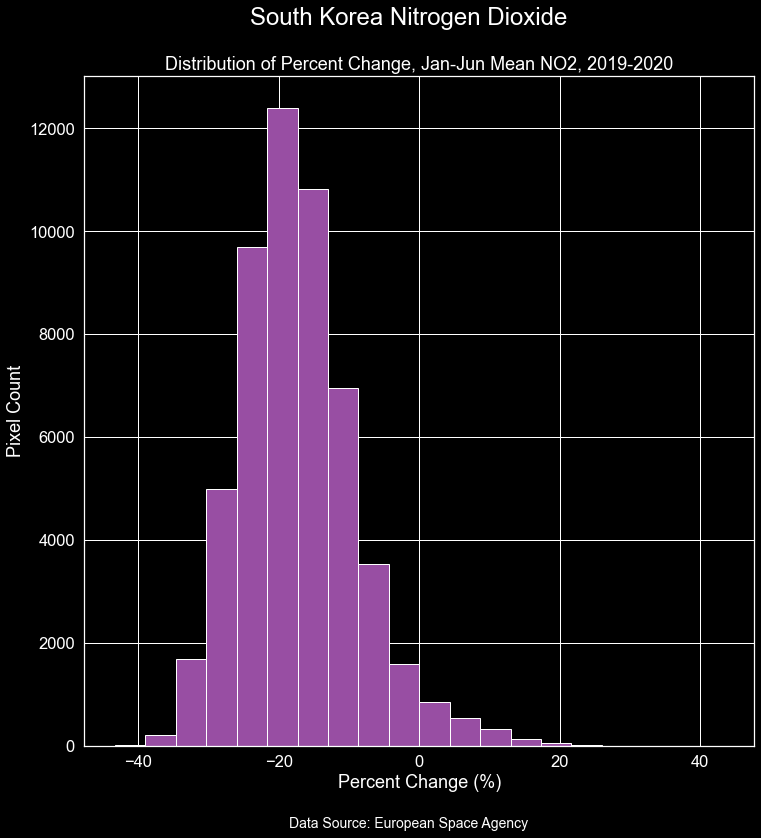

<IPython.core.display.Javascript object>

In [30]:
# Plot and export histogram of percent change
fig = stl.plot_histogram(percent_change)

rd.save_figure(
    os.path.join(
        "04-graphics-outputs",
        "histograms",
        "south-korea",
        "south-korea-no2-mean-change-percent-histogram-jan-jun-2019-2020.png",
    )
)

Saved plot: south-korea-no2-mean-full-study-area-jul-2018-2020.png


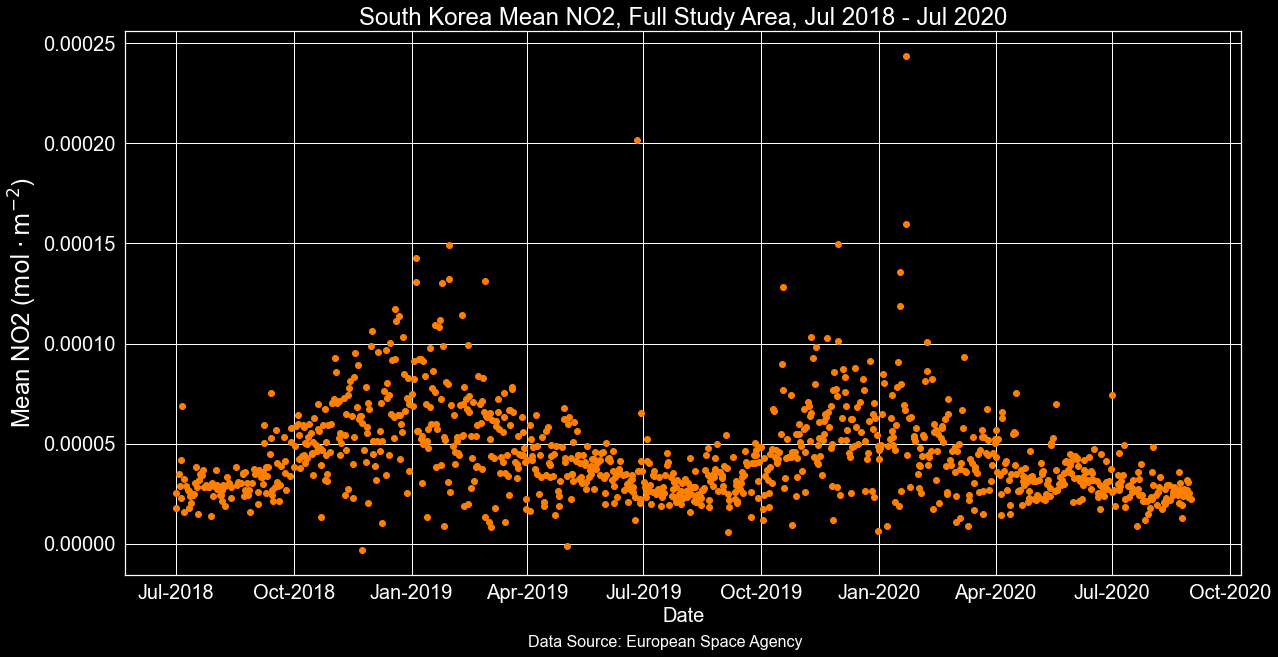

<IPython.core.display.Javascript object>

In [31]:
# Plot and export full study area time series mean
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(timestamps_arr, means_arr, facecolor="#ff7f00")
    ax.set_title(
        "South Korea Mean NO2, Full Study Area, Jul 2018 - Jul 2020", size=24
    )
    ax.set_xlabel("Date", size=20)
    ax.set_ylabel("Mean NO2 ($\mathrm{mol \cdot m^{-2}}$)", size=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    fig.text(
        0.5,
        0.025,
        "Data Source: European Space Agency",
        ha="center",
        fontsize=16,
    )

rd.save_figure(
    os.path.join(
        "04-graphics-outputs",
        "time-series",
        "south-korea",
        "south-korea-no2-mean-full-study-area-jul-2018-2020.png",
    )
)

Saved plot: south-korea-no2-percent-masked-full-study-area-jul-2018-2020.png


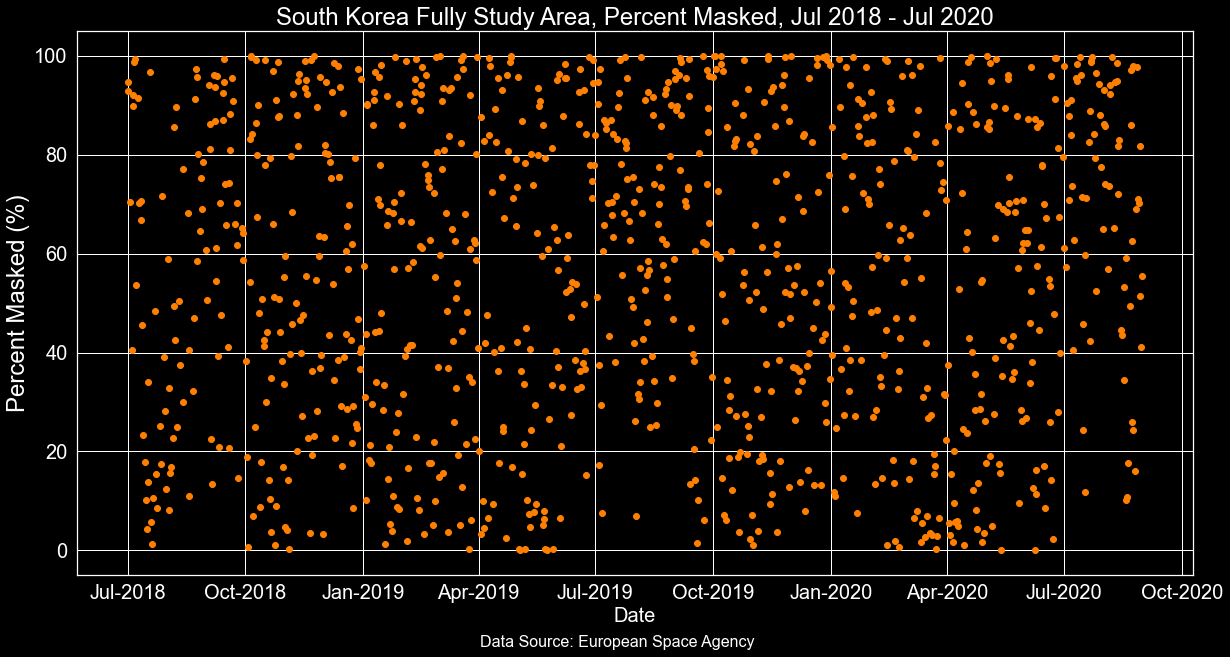

<IPython.core.display.Javascript object>

In [32]:
# Plot full study area time series percent masked
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.scatter(timestamps_arr, percent_masked_arr, facecolor="#ff7f00")
    ax.set_title(
        "South Korea Fully Study Area, Percent Masked, Jul 2018 - Jul 2020",
        size=24,
    )
    ax.set_xlabel("Date", size=20)
    ax.set_ylabel("Percent Masked (%)", size=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    date_form = DateFormatter("%b-%Y")
    ax.xaxis.set_major_formatter(date_form)
    fig.text(
        0.5,
        0.025,
        "Data Source: European Space Agency",
        ha="center",
        fontsize=16,
    )

rd.save_figure(
    os.path.join(
        "04-graphics-outputs",
        "time-series",
        "south-korea",
        "south-korea-no2-percent-masked-full-study-area-jul-2018-2020.png",
    )
)

### Georeferenced

In [33]:
# Extract metadata from GeoTiff
south_korea_metadata = stl.extract_geotiff_metadata(no2_2020_tif_path)
south_korea_metadata

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': nan,
 'width': 240,
 'height': 224,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.025, 0.0, 125.0,
        0.0, -0.025, 38.7)}

<IPython.core.display.Javascript object>

In [34]:
# Export NO2 change (magnitude and percent)
export_files = [
    (
        no2_difference,
        os.path.join(
            "03-processed-data",
            "raster",
            "south-korea",
            "change",
            "south-korea-no2-mean-change-jan-jun-2019-2020.tif",
        ),
    ),
    (
        percent_change,
        os.path.join(
            "03-processed-data",
            "raster",
            "south-korea",
            "change",
            "south-korea-no2-mean-change-percent-jan-jun-2019-2020.tif",
        ),
    ),
]

for (array, outpath) in export_files:
    rd.export_array(array, outpath, south_korea_metadata)

Exported: south-korea-no2-mean-change-jan-jun-2019-2020.tif
Exported: south-korea-no2-mean-change-percent-jan-jun-2019-2020.tif


<IPython.core.display.Javascript object>

In [35]:
# Unload Notebook formatter
%unload_ext nb_black

<IPython.core.display.Javascript object>